# Overview
This notebook is intended to demonstrate the _quarter-five spot_ problem (see e.g. https://users.wpi.edu/~sweekes/GEO/fivespot.html).

In simple terms, consider a domain with no-flow boundary (all neumann = 0). Let the lower-left corner be an injection well ($p_b=1$ on the boundary symmetrically about the corner) and the upper-right corner be a production well ($f=-1$ in that cell).

The governing equation and setup is described below.

## Setup
Let's setup the problem.

Recall, our aim is to solve single-phase flow,
$$-\nabla\cdot K \nabla p = f$$
over the domain $\Omega$. 

The boundary conditions will be defined over $\partial\Omega$, and are mathematically written as
$$p=p_b, \quad -K\nabla p \cdot \mathbf{n} = u_b$$
for Dirichlet ($\partial\Omega_d$) and Neumann ($\partial\Omega_n$) conditions respectively.

$f$ is a scalar source/sink term. $K$ is the permeability matrix. $p_b$ is the pressure at the boundary (Dirichlet), $u_b$ is the flux at the boundary (Neumann).

The basic setup is:
$$
\Omega = [0,1]^2, \quad 
\partial \Omega_d = \{\text{"boundary near origin"}\},\quad 
\partial \Omega_n = \partial\Omega \setminus \Omega_d
$$

with data: 
$$
f=0, \quad
K=1
\quad 
\text{ and }\quad  
u_b=0, \quad
p_b = 1
$$
And $f=-1$ at $(1,1)$

In [1]:
# Imports
import numpy as np
import scipy.sparse as sps
import porepy as pp

In [157]:
# Setup grid
Nx = Ny = 32
g = pp.CartGrid([Nx,Ny], [1,1])
g.compute_geometry()

In [159]:
### Boundary conditions ###

# Find indices of boundary faces
b_faces = g.tags['domain_boundary_faces'].nonzero()[0]

# Set all boundary faces to Neumann initially
labels = np.array(['neu']*b_faces.size)

# Create BoundaryCondition object
bc = pp.BoundaryCondition(g, b_faces, labels)

# Set no-flow condition on all boundaries initially
bc_val = np.zeros(g.num_faces)

In [175]:
### In-flow (Dirichlet) near Origin ###

# Coordinates and index of face centers
#coord_faces = np.array([g.face_centers[0, b_faces], g.face_centers[1, b_faces], np.array(range(b_faces.size))])
coord_faces = np.vstack((g.face_centers[0, b_faces], g.face_centers[1, b_faces], np.array(range(b_faces.size))))

# Find west face closest to (0,0)
left_face = coord_faces[:,coord_faces[0]==0]
ind_min_west = int(left_face[2,np.argmin(left_face[1])])
labels[ind_min_west] = 'dir'

# Find south face closest to (0,0)
bot_face = coord_faces[:,coord_faces[1]==0]
ind_min_south = int(bot_face[2,np.argmin(bot_face[0])])
labels[ind_min_south] = 'dir'

# Adjust Dirichlet value
bc_val[[ind_min_west, ind_min_south]] = -1

In [180]:
# Permeability
perm = pp.SecondOrderTensor(np.ones(g.num_cells))

# source
f = np.zeros(g.num_cells)
#f=g.cell_volumes

# Injection in lower-left corner. Production upper-right
f[-1] = -1

In [181]:
# Build problem
specified_parameters = {"second_order_tensor": perm, "source": f, "bc": bc, "bc_values": bc_val}
data = pp.initialize_default_data(g, {}, "flow", specified_parameters)

In [182]:
# Problem solution
solver = pp.Tpfa("flow")
solver.discretize(g, data)
A, b = solver.assemble_matrix_rhs(g, data)

# Manually descretize rhs (since tpfa does not discretize rhs)
s = pp.ScalarSource("flow")
s.discretize(g,data)
b1 = s.assemble_rhs(g, data)

# Solve
p = sps.linalg.spsolve(A, b+b1)

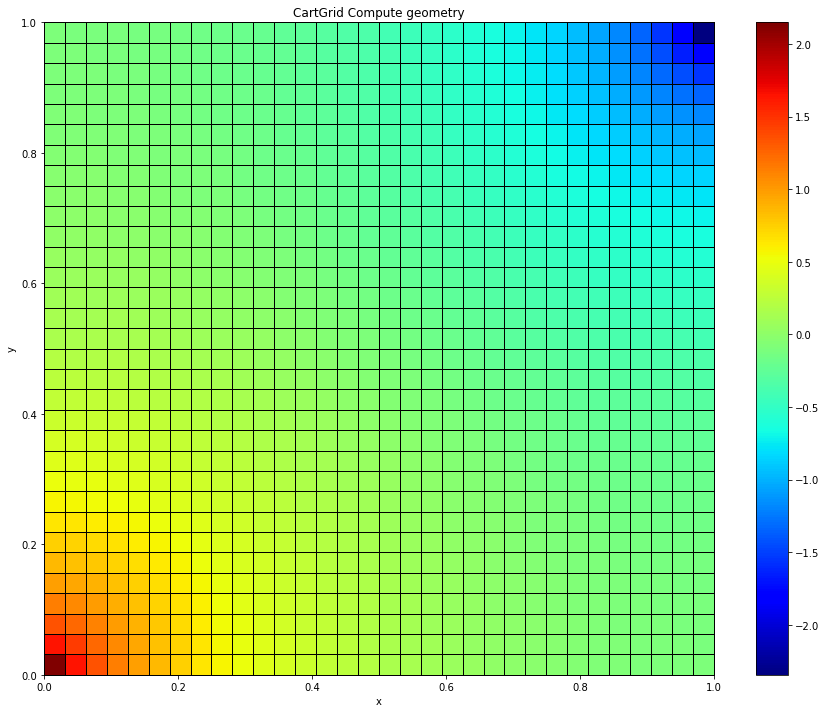

In [183]:
# Visualization
pp.plot_grid(g, p, figsize=(15, 12), plot_2d=True)